# Dataloader for Contrastive Loss

This notebook implements the dataloader needed for training the Siamese network later.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" #to suppress some unnecessary warnings
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from Utilities import DataLoaderContrastive, get_dataset_with_prefetching

## Scan the directories of the dataset

In [2]:
dataset_root_path = os.path.join('Data', 'CASIA', 'casia-webface')
classes_paths = []

# scan all classes directories
for class_dir in os.scandir(dataset_root_path):

    files = os.listdir(class_dir.path)
    classes_paths.append([])

    for file in files:
        classes_paths[-1].append(os.path.join(class_dir.path, file))

print(f"{len(classes_paths)} classes")

10572 classes


## Display a sample batch

In [3]:
train_loader = DataLoaderContrastive(dataset_root_path=dataset_root_path, batch_size=4, input_shape=(112, 112))

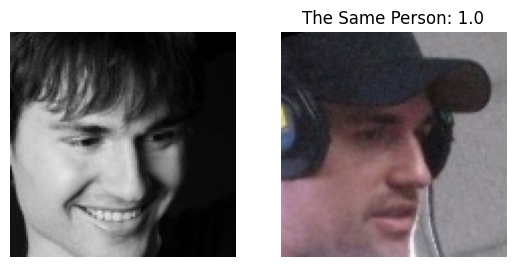

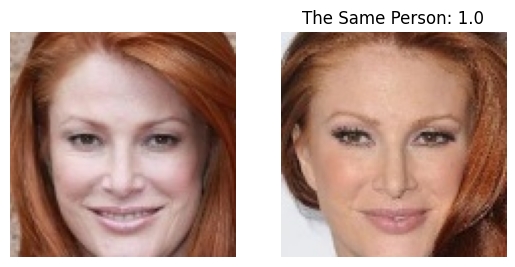

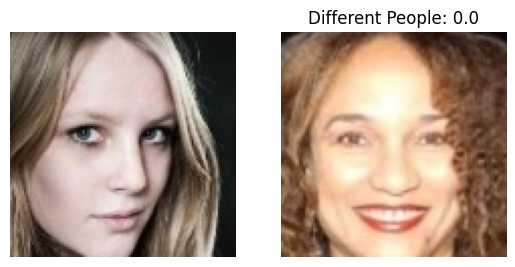

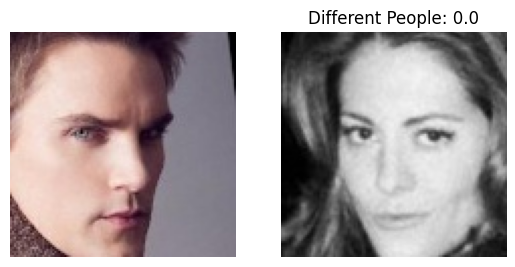

In [ ]:
# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# show the whole batch
for i in range(len(X1)):

    x1 = X1[i]
    x2 = X2[i]
    y_label = Y[i]

    plt.figure(i)

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(x1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(x2)

    if y_label[0] == 1:
        plt.title("The Same Person: " + str(y_label[0]))
    else:
        plt.title("Different People: " + str(y_label[0]))

plt.show()

## Test on Real Example

### Create a Test Model

In [ ]:
Input1 = keras.layers.Input(shape = (112, 112, 3))
Input2 = keras.layers.Input(shape = (112, 112, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(32, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


### Train the Model

In [9]:
train_loader = DataLoaderContrastive(dataset_root_path=dataset_root_path, batch_size=512, input_shape=(112, 112))

model.fit(train_loader, epochs = 1)



13/13 [==============================] - 645s 48s/step - loss: 3.6815 - accuracy: 0.4991


### Test the Model on an Example (After being Trained)

In [ ]:
# sample random batch
(X1, X2), y = train_loader[random.randint(0, len(train_loader)-1)]

# sample random pair
n = random.randint(0, X1.shape[0]-1)
x1, x2, y = X1[n], X2[n], y[n]

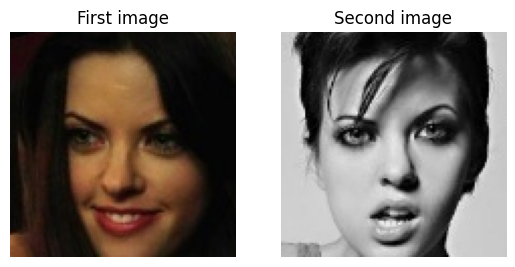

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [12]:
y = model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

print("Prediction is: " ,y[0])

1/1 [==============================] - 1s 568ms/step
Prediction is:  [0.500907]


## Optimize the data loader using tensorflow prefetching

In [ ]:
# This is how to turn the regular dataloader into a tensorflow dataset with prefetching enabled
#
#  dataset = tf.data.Dataset.from_generator(
#         DataLoader, 
#         args = [dataset_root_path, 32, (250, 250)], 
#         output_signature = ((tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32), tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32)), tf.TensorSpec(shape = (32, 1), dtype = tf.float32))
#  ).prefetch(tf.data.AUTOTUNE)


# Use the function implemented in the Utilities file instead
dataset = get_dataset_with_prefetching(dataset_root_path, 512)
model.fit(dataset, epochs = 3)